In [1]:
# Import important libraries
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
import copy
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import copy
import os
import torchvision.transforms as transforms
import shutil 
import os.path
from skimage.metrics import peak_signal_noise_ratio

In [2]:
# Assuming your CSV file is named 'your_dataframe.csv'
df = pd.read_csv('/kaggle/input/dataset-gtn/dataset.csv')

In [3]:
# Function to load image from path and convert to numpy array
def load_image_as_array(image_path):
    image = Image.open(image_path)
    return np.array(image)

# Create numpy arrays for ground truth and noisy images
X = []
y = []

# Set a fixed seed for reproducibility
np.random.seed(42)

# Sample 10,000 rows randomly
number_of_training_samples = 5000
sample_df = df.sample(number_of_training_samples,random_state=42)
count = 0
for index, row in sample_df.iterrows():
    count = count + 1
    if(count%1000 == 0):
        print(count)
    noisy_image_array = load_image_as_array(row['noisy'])
    ground_truth_array = load_image_as_array(row['ground_truth'])
    X.append(noisy_image_array)
    y.append(ground_truth_array)

X = np.array(X)
y = np.array(y)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [6]:
sample_df

,ground_truth,noisy
49196,/kaggle/input/dataset-a/174/00000086.png,/kaggle/input/set-b-c/174/00000086.png
15208,/kaggle/input/dataset-a/146/00000066.png,/kaggle/input/set-b-b/146/00000066.png
37382,/kaggle/input/dataset-a/008/00000017.png,/kaggle/input/set-b-c/008/00000017.png
48769,/kaggle/input/dataset-a/140/00000027.png,/kaggle/input/set-b-b/140/00000027.png
61528,/kaggle/input/dataset-a/154/00000065.png,/kaggle/input/set-b-b/154/00000065.png
...,...,...
6995,/kaggle/input/dataset-a/205/00000068.png,/kaggle/input/set-b-c/205/00000068.png
15883,/kaggle/input/dataset-a/175/00000036.png,/kaggle/input/set-b-b/175/00000036.png
17712,/kaggle/input/dataset-a/230/00000007.png,/kaggle/input/set-b-a/230/00000007.png
12551,/kaggle/input/dataset-a/127/00000088.png,/kaggle/input/set-b-c/127/00000088.png


In [4]:
def load_test(test_folder="/kaggle/input/test-dataset/custom_test"):

    test_dataset = torchvision.datasets.ImageFolder(root=test_folder)

    X_test = []
    y_test = []

    for img_path, _ in test_dataset.imgs:
        if("blur" in img_path):
            img = Image.open(img_path)
            img = np.array(img)
            X_test.append(img)
            y_test.append(np.array(Image.open(img_path.split("blur")[0]+"sharp"+img_path.split("blur")[1])))

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_test, y_test

In [5]:
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        target = self.y[idx]

        if self.transform:
            image = self.transform(image)
            target = self.transform(target)

        return image, target

# Assuming X and y are numpy arrays with shape (num_samples, height, width, channels)
# Assuming X and y are already preprocessed and normalized

# Split the dataset into train, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test, y_test = load_test()

# Define transformations if needed (e.g., ToTensor)
# Assuming you want to convert numpy arrays to PyTorch tensors
# and normalize them
transform = transforms.Compose([
    transforms.ToPILImage(),             # Convert numpy array to PIL image
    transforms.Resize((256, 256)),       # Resize to 256x256
    transforms.ToTensor()                # Convert PIL image to tensor
    # You can add more transformations if needed (e.g., normalization)
])

# Create datasets and dataloaders for train, validation, and test sets
train_dataset = CustomDataset(X_train, y_train, transform=transform)
val_dataset = CustomDataset(X_val, y_val, transform=transform)
test_dataset = CustomDataset(X_test, y_test, transform=transform)

# Define batch size
batch_size = 32

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
# class EAM(nn.Module):
#     def __init__(self):
#         super(EAM, self).__init__()
        
#         self.conv1 = nn.Conv2d(64, 64, kernel_size=3, dilation=1, padding=1)
#         self.conv2 = nn.Conv2d(64, 64, kernel_size=3, dilation=2, padding=2)
        
#         self.conv3 = nn.Conv2d(64, 64, kernel_size=3, dilation=3, padding=3)
#         self.conv4 = nn.Conv2d(64, 64, kernel_size=3, dilation=4, padding=4)
        
#         self.conv5 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        
#         self.conv6 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.conv7 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
#         self.conv8 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.conv9 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.conv10 = nn.Conv2d(64, 64, kernel_size=1, padding=0)
        
#         self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
#         self.conv11 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

#     def forward(self, x):
#         conv1 = F.relu(self.conv1(x))
#         conv1 = F.relu(self.conv2(conv1))
        
#         conv2 = F.relu(self.conv3(x))
#         conv2 = F.relu(self.conv4(conv2))
        
#         concat = torch.cat([conv1, conv2], dim=1)
#         conv3 = F.relu(self.conv5(concat))
#         add1 = x + conv3
        
#         conv4 = F.relu(self.conv6(add1))
#         conv4 = self.conv7(conv4)
#         add2 = conv4 + add1
#         add2 = F.relu(add2)
        
#         conv5 = F.relu(self.conv8(add2))
#         conv5 = F.relu(self.conv9(conv5))
#         conv5 = self.conv10(conv5)
#         add3 = conv5 + add2
#         add3 = F.relu(add3)
        
#         gap = self.gap(add3)
#         gap = gap.view(gap.size(0), -1, 1, 1)
#         conv6 = F.relu(self.conv11(gap))
#         conv6 = torch.sigmoid(self.conv12(conv6))
        
#         mul = conv6 * add3
#         out = x + mul
#         return out

# class RIDNet(nn.Module):
#     def __init__(self):
#         super(RIDNet, self).__init__()
        
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
#         self.eam1 = EAM()
#         self.eam2 = EAM()
#         self.eam3 = EAM()
#         self.eam4 = EAM()
#         self.conv2 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        
#     def forward(self, x):
#         conv1 = F.relu(self.conv1(x))
#         eam1 = self.eam1(conv1)
#         eam2 = self.eam2(eam1)
#         eam3 = self.eam3(eam2)
#         eam4 = self.eam4(eam3)
#         conv2 = self.conv2(eam4)
#         out = x + conv2
#         return out

# # Instantiate the model
# model = RIDNet()
# total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"Total Trainable Parameters: {total_params}")

Total Trainable Parameters: 1792451


In [6]:
class NoiseEstimationSubnetwork(nn.Module):
    def __init__(self):
        super(NoiseEstimationSubnetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        return x

class NonBlindDenoisingSubnetwork(nn.Module):
    def __init__(self):
        super(NonBlindDenoisingSubnetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, padding=0)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.AvgPool2d(kernel_size=2, padding=0)
        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upsample1 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv10 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv11 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.upsample2 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv12 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv14 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.upsample2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv15 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv16 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.out = nn.Conv2d(64, 3, kernel_size=1, padding=0)

    def forward(self, x):
        conv1 = F.relu(self.conv1(x))
        conv2 = F.relu(self.conv2(conv1))    
        pool1 = self.pool1(conv2)        
        conv3 = F.relu(self.conv3(pool1))
        conv4 = F.relu(self.conv4(conv3))
        conv5 = F.relu(self.conv5(conv4))
        pool2 = self.pool2(conv5)
        conv6 = F.relu(self.conv6(pool2))
        conv7 = F.relu(self.conv7(conv6))
        pool3 = self.pool2(conv7)
        conv8 = F.relu(self.conv8(pool3))
        conv9 = F.relu(self.conv9(conv8))
        upsample1 = F.relu(self.upsample1(conv9))
        conv10 = F.relu(self.conv10(upsample1))
        conv11 = F.relu(self.conv11(conv10))
        upsample2 = F.relu(self.upsample1(conv11))
        add1 = conv5 + upsample2
        conv12 = F.relu(self.conv12(add1))
        conv13 = F.relu(self.conv13(conv12))
        conv14 = F.relu(self.conv14(conv13))
        upsample3 = F.relu(self.upsample2(conv14))
        add2 = conv2 + upsample3
        conv15 = F.relu(self.conv15(add2))
        conv16 = F.relu(self.conv16(conv15))
        out = self.out(conv16)
        out = out + x
        return out

class CBDNet(nn.Module):
    def __init__(self):
        super(CBDNet, self).__init__()
        self.noise_estimation = NoiseEstimationSubnetwork()
        self.denoising = NonBlindDenoisingSubnetwork()

    def forward(self, x):
        noise_map = self.noise_estimation(x)
#       x = torch.cat((noise_map, x), dim=1)
        x = self.denoising(x)
        return x

# Create an instance of the model
model = CBDNet()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params}")

Total Trainable Parameters: 6633350


In [7]:
#PLOTS
TRAINING_LOSS = []
VALIDATION_LOSS = []

f = open("/kaggle/working/Log.txt", 'a')
f.truncate(0)

#Total Number of parameters in the model
f.write(f"\nTotal number of parameters in the model: {total_params}\n")
f.write(f"Noumber of training samples: {number_of_training_samples}\n")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the available device
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
learning_rate = 0.005
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

f.write(f"Learning rate: {learning_rate}\n")

print_every = 50
total_batches = len(train_loader)
min_val_loss = 10
stop_count = 3
running_loss = 0
epoch_loss = 0
val_loss = 0
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    if(stop_count > 3 or epoch == num_epochs):
        break

    model.train()
    start_time = time.time()

    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if (i + 1) % print_every == 0 or (i + 1) == total_batches:
            avg_loss = running_loss/print_every
            print(f"Training Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{total_batches}], Loss: {avg_loss:.8f}")
            f.write(f"Training Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{total_batches}], Loss: {avg_loss:.8f}\n")
            epoch_loss += running_loss
            running_loss = 0
    epoch_loss = epoch_loss / len(train_loader)
    TRAINING_LOSS.append(epoch_loss)
    
    print(f'Epoch Loss: {epoch_loss:.8f}')
    f.write(f'Epoch Loss: {epoch_loss:.8f}\n')
    
    epoch_loss = 0

    # Validation
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
    val_loss = val_loss/len(val_loader)       
    VALIDATION_LOSS.append(val_loss)
    
    # Stoping criteria
    if(val_loss < min_val_loss):
        min_val_loss = val_loss
        torch.save(model.state_dict(), '/kaggle/working/model.pth')
        stop_count = 0
    else:
        stop_count += 1
    
    print(f"Validation - Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss / len(val_loader):.8f}\n")
    f.write(f"Validation - Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss / len(val_loader):.8f}\n")
    
    print(f"Time taken for epoch {epoch + 1}: {time.time() - start_time:.2f} seconds\n")
    f.write(f"Time taken for epoch {epoch + 1}: {time.time() - start_time:.2f} seconds\n")

Training Epoch [1/10], Batch [50/250], Loss: 0.23839357
Training Epoch [1/10], Batch [100/250], Loss: 0.00116937
Training Epoch [1/10], Batch [150/250], Loss: 0.00115604
Training Epoch [1/10], Batch [200/250], Loss: 0.00115155
Training Epoch [1/10], Batch [250/250], Loss: 0.00116926
Epoch Loss: 0.04860796
Validation - Epoch [1/10], Validation Loss: 0.00001853

Time taken for epoch 1: 235.00 seconds

Training Epoch [2/10], Batch [50/250], Loss: 0.00119973
Training Epoch [2/10], Batch [100/250], Loss: 0.00117224
Training Epoch [2/10], Batch [150/250], Loss: 0.00115289
Training Epoch [2/10], Batch [200/250], Loss: 0.00113708
Training Epoch [2/10], Batch [250/250], Loss: 0.00115193
Epoch Loss: 0.00116277
Validation - Epoch [2/10], Validation Loss: 0.00001879

Time taken for epoch 2: 234.55 seconds

Training Epoch [3/10], Batch [50/250], Loss: 0.00114817
Training Epoch [3/10], Batch [100/250], Loss: 0.00117628
Training Epoch [3/10], Batch [150/250], Loss: 0.00112248
Training Epoch [3/10], B

In [8]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to store test loss and the number of test samples
test_loss = 0.0
num_samples_loss = 0
total_psnr = 0.0
num_samples_psnr = 0

# Iterate over the test dataset
with torch.no_grad():  # Disable gradient computation for inference
    for images, targets in test_loader:
        
        # Move images to the device
        images = images.to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Convert torch tensors to numpy arrays
        outputs_np = outputs.cpu().detach().numpy()
        targets_np = targets.cpu().detach().numpy()
        
        # Compute PSNR for each image pair in the batch
        batch_psnr = peak_signal_noise_ratio(targets_np, outputs_np, data_range=1.0)
     
        # Update total PSNR and number of samples
        total_psnr += batch_psnr
        num_samples_psnr += batch_psnr.size
        
        # Compute the loss
        loss = criterion(outputs, images)
        
        # Update the total test loss and the number of samples
        test_loss += loss.item() * images.size(0)
        num_samples_loss += images.size(0)

# Compute the average test loss
average_test_loss = test_loss / num_samples_loss
print(f'Average Test Loss: {average_test_loss:.8f}')
f.write(f'Average Test Loss: {average_test_loss:.8f}\n')

# Calculate average PSNR
average_psnr = total_psnr / num_samples_psnr
print(f'Average PSNR: {average_psnr:.2f} dB')
f.write(f'Average PSNR: {average_psnr:.2f} dB')

f.close()

Average Test Loss: 0.00000002
Average PSNR: 28.87 dB


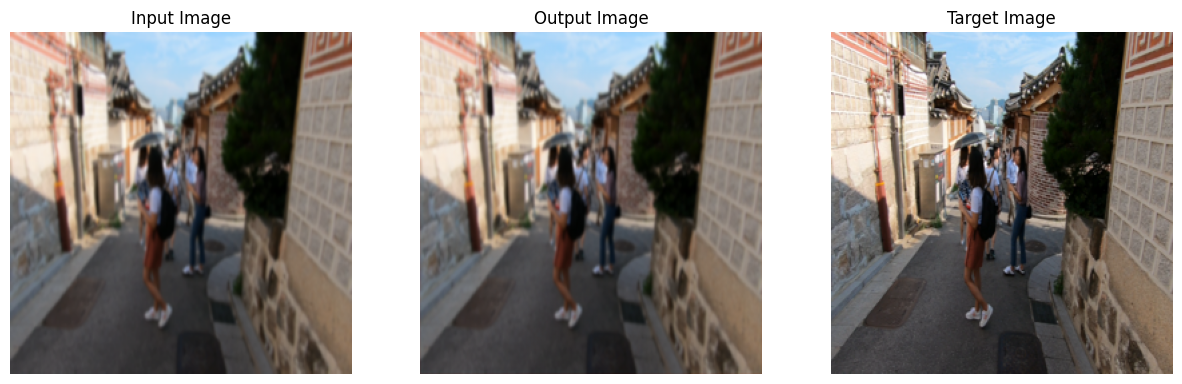

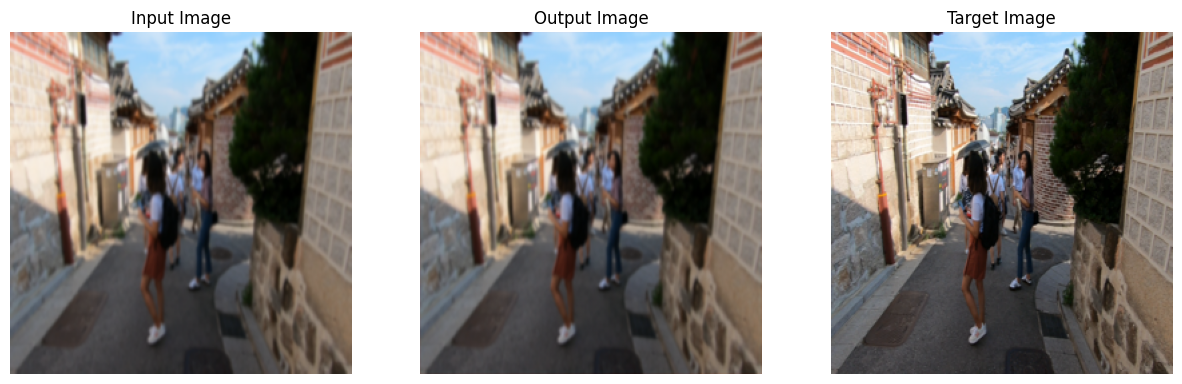

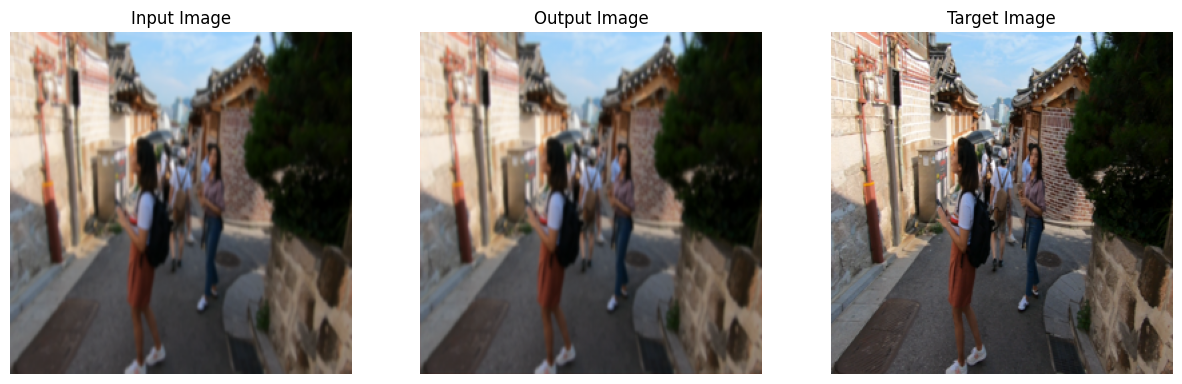

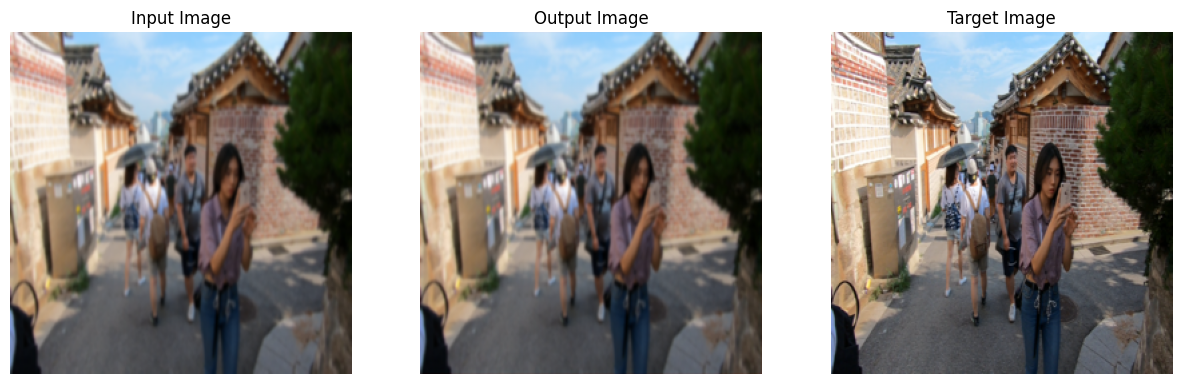

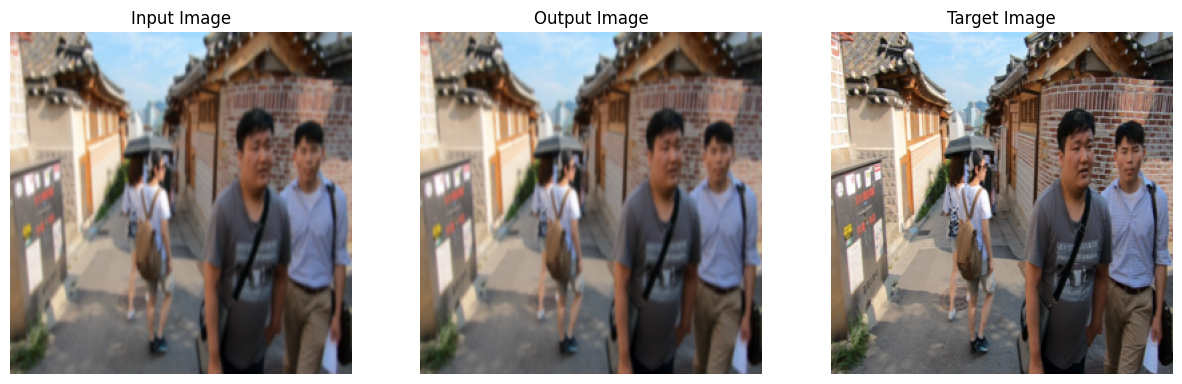

In [9]:
model.load_state_dict(torch.load("/kaggle/working/model.pth"))

# Set the model to evaluation mode
model.eval()

# Get a batch of test data
images, targets = next(iter(test_loader))

# Move images to the device
images = images.to(device)

# Forward pass
outputs = model(images)

# Convert tensors to numpy arrays
images = images.cpu().numpy()
outputs = outputs.cpu().detach().numpy()
targets = targets.numpy()

# Plot a few input, output, and target images
num_samples = 5
for i in range(num_samples):
    plt.figure(figsize=(15, 5))
    
    # Input image
    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    plt.title('Input Image')
    plt.axis('off')
    
    # Output image
    plt.subplot(1, 3, 2)
    plt.imshow(np.transpose(outputs[i], (1, 2, 0)))
    plt.title('Output Image')
    plt.axis('off')
    
    # Target image
    plt.subplot(1, 3, 3)
    plt.imshow(np.transpose(targets[i], (1, 2, 0)))
    plt.title('Target Image')
    plt.axis('off')
    
    plt.show()

In [10]:
clip_transform = transforms.Lambda(lambda x: x.clamp(0, 1))

# Step 1: Define transformations
load_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor()           # Convert to tensor
])

resize_transform = transforms.Compose([
    clip_transform,
    transforms.ToPILImage(),      # Convert to PIL image
    transforms.Resize((256,448)),  # Resize to original dimensions
])

# Step 2: Load images from the custom test folder
test_folder = '/kaggle/input/test-dataset/custom_test'
test_dataset = torchvision.datasets.ImageFolder(root=test_folder, transform=load_transform)
blur_imgs = []

for img_path, _ in test_dataset.imgs:
    if("blur" in img_path):
        blur_imgs.append(img_path)

blur_imgs = np.array(blur_imgs)

# Step 3: Pass images through the model for testing
output_folder = 'output_images'
os.makedirs(output_folder, exist_ok=True)
for img_path in blur_imgs:
    
    # Load and preprocess the image
    img = Image.open(img_path)
    img_tensor = load_transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Forward pass through the model
    with torch.no_grad():
        output_tensor = model(img_tensor)
     
    # Clip the output the values in range(0-1)
    clipped_tensor = torch.clamp(output_tensor, 0, 1)
    
    # Resize output image to original dimensions
    output_img = resize_transform(clipped_tensor.squeeze().cpu())
    
    # Save resized output image
    output_img.save(os.path.join(output_folder, os.path.basename(img_path)))

print("Testing and saving finished.")

Testing and saving finished.


In [12]:
# Creating the ZIP file 
archived = shutil.make_archive('/kaggle/working/output_images', 'zip', '/kaggle/working/output_images')

In [15]:
import os
from skimage.metrics import peak_signal_noise_ratio
from skimage.io import imread

def psnr_between_folders(folder1, folder2):
    psnr_values = []
    
    # Get list of filenames in folder1
    filenames = os.listdir(folder1)
    
    for filename in filenames:
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Read corresponding images from both folders
            img_path1 = os.path.join(folder1, filename)
            img_path2 = os.path.join(folder2, filename)
            img1 = imread(img_path1)
            img2 = imread(img_path2)
            
            # Compute PSNR between corresponding images
            psnr = peak_signal_noise_ratio(img1, img2)
            psnr_values.append(psnr)
    
    # Compute average PSNR across all images    
    avg_psnr = sum(psnr_values) / len(psnr_values)
    
    return avg_psnr

# Example usage:
folder1 = "/kaggle/input/test-dataset/custom_test/sharp"
folder2 = "/kaggle/input/model-10k"

avg_psnr = psnr_between_folders(folder1, folder2)
print(f"Average PSNR between corresponding images: {avg_psnr} dB")

Average PSNR between corresponding images: 25.820794081573833 dB
